# Passing Analysis

In this notebook we build a model analyzing pass success probabilities. We first approach the problem utilizing a generalized additive model (GAM) using the logistic link function to represent the probability of pass success. The GAM model is fit using a variety of smoothing functions, including tensor product splines to account for the spatial relationship between the origin and destination coordinates of a pass.

The planned next step for this analysis is to provide an in-depth analysis of players' passing abilities. This will be done using the predicted probability of success for each pass a player takes and evaluating how well they out-perform or under-perform these predictions.

The data used for this analysis, as well as some data importing code, were accessed from:

* Pappalardo, Luca; Massucco, Emanuele (2019): Soccer match event dataset. figshare. Collection. https://doi.org/10.6084/m9.figshare.c.4415000

* Pappalardo, L., Cintia, P., Rossi, A. et al. A public data set of spatio-temporal match events in soccer competitions. Sci Data 6, 236 (2019) doi:10.1038/s41597-019-0247-7, https://www.nature.com/articles/s41597-019-0247-7

## Importing packages

In [1]:
import json
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Ellipse
from IPython.display import clear_output
import seaborn as sns
sns.set_theme()
from sklearn.neighbors import KernelDensity
import matplotlib.colors as mcolors
from sklearn import metrics
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import train_test_split
from pygam import LogisticGAM, te, s, f, l

import warnings
warnings.filterwarnings('ignore')

## Data setup

The code below loads in the events and matches data and then identifies passes and pulls them into a dataframe. Due to the significant volume of pass observations, we focused exclusively on the English Premier League to manage computation time for the analysis. The following code is nonetheless setup to facilitate adding in the remaining European domestic leagues if desired.

In [2]:
events={}
nations = ['England']
for nation in nations:
    with open('events/events_%s.json' %nation) as json_data:
        events[nation] = json.load(json_data)

matches={}
nations = ['England']
for nation in nations:
    with open('matches/matches_%s.json' %nation) as json_data:
        matches[nation] = json.load(json_data)

The code below identifies the pass events in the events data. We enumerate the iteration over the events in order to identify information on the preceding events (e.g. previous type of event before a pass). Additionally, we pass over the first event at the start of each half as this will just be the kick-off pass, which won't provide any useful information.

In [3]:
event_name = 'Pass'
event_ids = [80,81,82,83,84,85,86]
passes = []

for nation in nations:
    for index, ev in enumerate(events[nation]):
        if ((index == 0) |
            (ev['matchId'] != events[nation][index-1]['matchId']) |
            (ev['matchPeriod'] != events[nation][index-1]['matchPeriod'])):
            pass
        
        elif ev['subEventId'] in event_ids:
            tags = []
            for i in range(len(ev['tags'])):
                tags.append(ev['tags'][i]['id'])
            passes.append([ev['matchId'], ev['playerId'], ev['matchPeriod'], ev['eventSec'], ev['id'],
                           ev['teamId'], nation, ev['subEventId'], tags, ev['positions'][0]['x'],
                           100-ev['positions'][0]['y'], ev['positions'][1]['x'], 100-ev['positions'][1]['y'],
                           events[nation][index-1]['subEventId'], ev['eventSec']-events[nation][index-1]['eventSec']])
        else:
            pass

df_passes = pd.DataFrame(passes, columns=['matchId','playerId','matchPeriod','eventSec','id','teamId',
                                          'nation','eventId','tags','start_x','start_y',
                                          'end_x','end_y','prev_event','time_from_prev_event'])

print('Number of passes observed: {:.0f}'.format(len(df_passes)))

Number of passes observed: 327902


## Feature engineering

#### Home, Away, and teamIds

The first feature we identify are whether the team attempting a pass is the home team or away team. This requires pulling information from the matches data we imported above, and is performed in the first cell below. Lastly, we convert the home/away information to an indicator variable.

The next step was to identify the teamId of the opposing team for an attempted pass. This was done by identifying whether the pass was made by the home team or the away team, and then pulling the opposite teamId. The teamId for the team performing the pass is already included as part of the data on the pass event.

In [4]:
match_data = []

for nation in nations:
    for ma in matches[nation]:
        team_1 = list(ma['teamsData'].keys())[0]
        team_2 = list(ma['teamsData'].keys())[1]
        match_data.append([ma['wyId'],int(team_1),ma['teamsData'][team_1]['side'],nation])
        match_data.append([ma['wyId'],int(team_2),ma['teamsData'][team_2]['side'],nation])
        
df_match = pd.DataFrame(match_data, columns=['matchId','teamId','homeaway','nation'])

df_passes = df_passes.merge(df_match.drop(['nation'],axis=1), how='left', on=['matchId', 'teamId'])

le = preprocessing.LabelEncoder()
df_passes['homeaway'] = le.fit_transform(df_passes['homeaway'])

In [5]:
def opp_team(x):
    if x == 1:
        return 'away'
    elif x == 0:
        return 'home'

df_passes['oppId'] = df_passes['homeaway'].apply(lambda x: opp_team(x))

df_passes['oppId'] = df_passes.merge(df_match, how='left', left_on=['matchId', 'oppId'],
                                     right_on=['matchId','homeaway'])['teamId_y']

#### Tags

We next want to obtain some information from the tags list we obtained for each pass event. We apply the count function to the tags list to identify whether the specific tag is in the list.

In [6]:
# Create the pass success/failure indicator by identifying whether the complete pass tag is included.

df_passes['success'] = df_passes['tags'].apply(lambda x: x.count(1801))

# Removing any passes with either of the 102 (own goal) or 1001 (fairplay) tags. Based on a review of the data there
# weren't any other problematic tags to remove.

df_passes = df_passes.loc[df_passes['tags'].apply(lambda x: x.count(102) + x.count(1001)) == 0]

#### Miscellaneous

In [7]:
# Passes that go out of play are assigned an end position from the corners. Therefore, we remove any passes with any
# of these ending coordinates

df_passes = df_passes.loc[~(df_passes['end_x'].isin([0,100]) & df_passes['end_y'].isin([0,100]))]

# The data presents the event times as the elapsed time since the previous kick-off. Therefore, the second half restarts
# at 0. In order to identify a more reasonable representation of the time in the game we add the equivalent of 46 minutes
# to the event times for second half events.

df_passes.loc[df_passes['matchPeriod'] == '2H', 'eventSec'] += 2760

# Lastly, we reset the index now that we have completed filtering our data.

df_passes = df_passes.reset_index().drop(['index'],axis=1)

## Modelling
#### Creating training data

In order to address the unbalanced nature of the dataset, we undersample successful passes in order to get an equally proportioned set of successful and failed passes.

The code below results in a training set of 50,000 observations with balanced observations, and a test set of 15000 with the normal, unbalanced observations.

In [8]:
X = df_passes.drop(['matchId','playerId','matchPeriod','id','nation','tags'], axis=1)

# Split the data into training and testing groups to ensure no cross-over in the subsequent steps.

train, test = train_test_split(X, test_size=15000)

# Subsample from the training data 25000 successful and 25000 failed passes.

train_success = train.loc[train['success']==1].sample(25000)
train_fail = train.loc[train['success']==0].sample(25000)

# Combine the subsamples and prepare the final training and test data.

train = pd.concat([train_success,train_fail],axis=0)
train = train.sample(frac=1)

X_train = train.drop(['success'],axis=1)
y_train = train['success']

X_test = test.drop(['success'],axis=1)
y_test = test['success']

#### Fitting the GAM

Here we set-up and fit the model using the training data. The pyGAM package has tensor product splines (**te**), smoothing splines (**s**), factor terms (**f**) and linear terms (**l**, not used).

The factor terms are one-hot encoded to identify a fixed effect for each class in the specific variable. The factor variables include **pass type**, **teamId**, **opposing teamId**, and **preceding event type**. The smoothing spline terms fit several splines to the individual variables. The smoothing spline terms include **event time** and **time from previous event**. Lastly, the tensor product splines enables us to account for the inter-relationships of the x,y-coordinates of the **origin** and **destination** of the passes. We use tensor splines for the four coordinates, as well the pairs of x-coordinate and y-coordinates of the origin and destination of the passes.

Each of the spline terms are fitted with a penalty on the curvature of the splines. For the spatial variables we loosen the curvature penalties, and use a relatively looser penalty for x-coordinates given they are more compressed relative to y-coordinates when transformed into a 0-100 interval. We also limit the number of splines for the tensor terms as the higher dimensions cause very high computation requirements.

For the remaining variables we use the default smoothing penalty and number of splines as we found they perform well for these terms.

In [9]:
gam = LogisticGAM(s(0)+
                  f(1, coding='one-hot')+
                  f(2, coding='one-hot')+
                  te(3,4,5,6, n_splines=9, lam=[0.0005,0.00075,0.0005,0.00075])+
                  te(3,5, n_splines=7, lam=[0.0005,0.0005])+
                  te(4,6, n_splines=7, lam=[0.00075,0.00075])+
                  f(7, coding='one-hot')+
                  s(8)+
                  f(9)+
                  f(10, coding='one-hot'),
                  max_iter=1000)

gam = gam.fit(X_train, y_train)

gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                    979.9054
Link Function:                        LogitLink Log Likelihood:                                -23130.5032
Number of Samples:                        50000 AIC:                                            48220.8172
                                                AICc:                                           48260.1152
                                                UBRE:                                               2.9801
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3326
Feature Function                  Lam

#### Model assessment

Below we assess the log loss and classification report for the model on the test data.

Overall our model performs fairly well. The model still performs worse on failed passes, despite our balancing of the training data. Unsuccessful passes are very difficult to predict as they depend on many contextual factors that are not present in the events data (e.g. proximity of defenders to the passer/receiver).

In [10]:
preds = gam.predict(X=X_test)
prob_preds = gam.predict_mu(X=X_test)

print(' Log loss: {:.2f}'.format(metrics.log_loss(y_test,prob_preds)),'\n\n',
      'Classification report:\n', metrics.classification_report(y_test,preds))

 Log loss: 0.49 

 Classification report:
               precision    recall  f1-score   support

           0       0.42      0.74      0.54      2519
           1       0.94      0.79      0.86     12481

    accuracy                           0.78     15000
   macro avg       0.68      0.77      0.70     15000
weighted avg       0.85      0.78      0.80     15000



#### Visualization

Below we will plot the pass success probability surfaces for a typical pass from 9 different locations on the pitch. We evaluate the pass origins on a coarse grid of 9 points, and then evaluate the success probabilities from each of these 9 points across the full pitch surface.

The first cell below creates our pitch plotting function which we will use to visualize the pass probability surfaces.

In [11]:
def pitch(ax, color='black', grass=False, axis=True, arrow=True):

    #Pitch Outline & Centre Line
    ax.plot([0,0],[0,100], color=color)
    ax.plot([0,100],[100,100], color=color)
    ax.plot([100,100],[100,0], color=color)
    ax.plot([100,0],[0,0], color=color)
    ax.plot([50,50],[0,100], color=color)

    #Left Penalty Area
    ax.plot([16.5,16.5],[80,20],color=color)
    ax.plot([0,16.5],[80,80],color=color)
    ax.plot([16.5,0],[20,20],color=color)

    #Right Penalty Area
    ax.plot([83.5,100],[80,80],color=color)
    ax.plot([83.5,83.5],[80,20],color=color)
    ax.plot([83.5,100],[20,20],color=color)

    #Left 6-yard Box
    ax.plot([0,5.5],[65,65],color=color)
    ax.plot([5.5,5.5],[65,35],color=color)
    ax.plot([5.5,0.5],[35,35],color=color)

    #Right 6-yard Box
    ax.plot([100,94.5],[65,65],color=color)
    ax.plot([94.5,94.5],[65,35],color=color)
    ax.plot([94.5,100],[35,35],color=color)

    #Prepare Circles
    centreCircle = Ellipse((50, 50), width=30, height=39, edgecolor=color, facecolor="None", lw=1.8)
    centreSpot = Ellipse((50, 50), width=1, height=1.5, edgecolor=color, facecolor=color, lw=1.8)
    leftPenSpot = Ellipse((11, 50), width=1, height=1.5, edgecolor=color, facecolor=color, lw=1.8)
    rightPenSpot = Ellipse((89, 50), width=1, height=1.5, edgecolor=color, facecolor=color, lw=1.8)

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)
    
    #limit axis
    ax.set_xlim(0,100)
    ax.set_ylim(0,100)
    
    img = plt.imread("pitch.png")
    
    #Add grass background
    if grass == True:
        ax.imshow(img, aspect='auto', extent =[0,100,0,100])
    
    #Turn off axis
    if axis == False:
        ax.axis('off')
    
    #Add attacking arrow indication
    if arrow == True:
        ax.annotate("", xy=(25, 5), xytext=(5, 5),
                    arrowprops=dict(arrowstyle="->", linewidth=1, color='black'))
        
    return fig,ax

The next cell below initializes the non-spatial values for our visualization, which are set to typical/average values to give a representative visualization. We also define a coarse grid that we will evaluate the pass origins on, and define a fine grid covering the full pitch to evaluate the destinations of passes.


In [12]:
params = {
    'game_time': 2700,
    'passing_team': 1613,
    'pass_type': 85,
    'start_x': [25,50,75],
    'start_y': [75,50,25],
    'prev_event_id': 85,
    'time_from_prev_event': 3,
    'home': 1,
    'opp_team': 1628
}

X0 = np.full((51,51), fill_value=params['game_time']).flatten()
X1 = np.full((51,51), fill_value=params['passing_team']).flatten()
X2 = np.full((51,51), fill_value=params['pass_type']).flatten()
X5, X6 = np.mgrid[0:100:51j,100:0:51j]
X7 = np.full((51,51), fill_value=params['prev_event_id']).flatten()
X8 = np.full((51,51), fill_value=params['time_from_prev_event']).flatten()
X9 = np.full((51,51), fill_value=params['home']).flatten()
X10 = np.full((51,51), fill_value=params['opp_team']).flatten()

Here we evaluate the model at the 9 different origin points for passes and plot the pass probability surfaces from each of these location on the pitch.

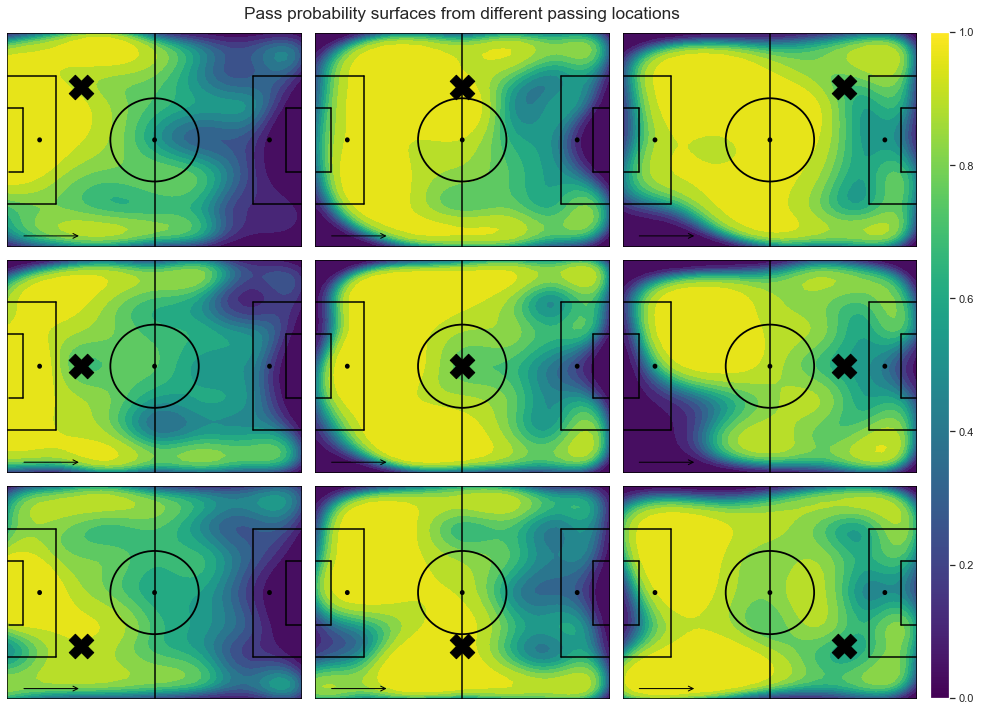

In [13]:
fig, ax = plt.subplots(3,3,figsize=(13,10))
levels = np.linspace(0,1,15)

for i in range(3):
    for j in range(3):
        pitch(ax[i,j],'black', grass=False, axis=False)

        X3 = np.full((51,51), fill_value=params['start_x'][j])
        X4 = np.full((51,51), fill_value=params['start_y'][i])
        XX = np.vstack((X0,X1,X2,X3.flatten(),X4.flatten(),X5.flatten(),X6.flatten(),X7,X8,X9,X10)).T

        Z = gam.predict_mu(X=XX)
        Z = Z.reshape(len(X5),len(X6))

        sc = ax[i,j].contourf(X5,100-X6,Z, cmap='viridis', levels=levels)

        ax[i,j].scatter(params['start_x'][j],params['start_y'][i], marker='X', s=600, c='black')


norm = mpl.colors.Normalize(vmin=0, vmax=1)
cbar_ax = fig.add_axes([1.0, 0.02, 0.02, 0.925])
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='viridis'), cax=cbar_ax)

fig.suptitle('Pass probability surfaces from different passing locations', fontsize="x-large")

plt.tight_layout()
plt.show()

## Conclusion and next steps

Our model performs well on the passing data and provides interpretable and intuitive probability surfaces for passes. Despite mitigating efforts, predicting unsucessful passes remains difficult. Improvements in this regard would likely require utilizing tracking data with more contextual information, particularly the spatial orientation of defenders.

My planned next steps will be to utilize this model to assess players' passing performance. This will be done by assessing individual players' pass outcomes against the assessed difficulty of the passes they take (as measured by the predicted success probability).